In [2]:
import os
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [4]:
data_path = "../data"

In [ ]:
imu_df=pd.read_csv(f'{data_path}/imu.csv')

In [ ]:
imu_df.head()

Use CNN for each task
- Cup placing

In [ ]:
imu_cup_df=imu_df[imu_df['task'] == 'Cupplacing']

visualize all accelerometer data

In [ ]:
for participant in imu_cup_df['participant'].unique():
    for body_part in imu_cup_df['body_part'].unique():
        for condition in imu_cup_df['condition'].unique():
            subset = imu_cup_df[(imu_cup_df['participant'] == participant) &
                                (imu_cup_df['body_part'] == body_part) &
                                (imu_cup_df['condition'] == condition)]

            plt.figure(figsize=(15, 4))
            plt.plot(subset['PacketCounter'], subset['Acc_X'], label='Acc_X')
            plt.plot(subset['PacketCounter'], subset['Acc_Y'], label='Acc_Y')
            plt.plot(subset['PacketCounter'], subset['Acc_Z'], label='Acc_Z')
            plt.title(f'{participant} - {body_part} - {condition}')
            plt.legend()
            # Create a directory named 'images' if it doesn't exist
            os.makedirs(f'{data_path}/acc_images', exist_ok=True)
            plt.savefig(f'{data_path}/acc_images/{participant}_{body_part}_{condition}.png')  # Save as image
            plt.close()

visualize all gyroscope data

In [ ]:
for participant in imu_cup_df['participant'].unique():
    for body_part in imu_cup_df['body_part'].unique():
        for condition in imu_cup_df['condition'].unique():
            subset = imu_cup_df[(imu_cup_df['participant'] == participant) &
                                (imu_cup_df['body_part'] == body_part) &
                                (imu_cup_df['condition'] == condition)]

            plt.figure(figsize=(15, 4))
            plt.plot(subset['PacketCounter'], subset['Gyr_X'], label='Gyr_X')
            plt.plot(subset['PacketCounter'], subset['Gyr_Y'], label='Gyr_Y')
            plt.plot(subset['PacketCounter'], subset['Gyr_Z'], label='Gyr_Z')
            plt.title(f'{participant} - {body_part} - {condition}')
            plt.legend()
            # Create a directory named 'images' if it doesn't exist
            os.makedirs(f'{data_path}/gyr_images', exist_ok=True)
            plt.savefig(f'{data_path}/gyr_images/{participant}_{body_part}_{condition}.png')  # Save as image
            plt.close()

visualize all magnetometer data

In [ ]:
for participant in imu_cup_df['participant'].unique():
    for body_part in imu_cup_df['body_part'].unique():
        for condition in imu_cup_df['condition'].unique():
            subset = imu_cup_df[(imu_cup_df['participant'] == participant) &
                                (imu_cup_df['body_part'] == body_part) &
                                (imu_cup_df['condition'] == condition)]

            plt.figure(figsize=(15, 4))
            plt.plot(subset['PacketCounter'], subset['Mag_X'], label='Mag_X')
            plt.plot(subset['PacketCounter'], subset['Mag_Y'], label='Mag_Y')
            plt.plot(subset['PacketCounter'], subset['Mag_Z'], label='Mag_Z')
            plt.title(f'{participant} - {body_part} - {condition}')
            plt.legend()
            # Create a directory named 'images' if it doesn't exist
            os.makedirs(f'{data_path}/mag_images', exist_ok=True)
            plt.savefig(f'{data_path}/mag_images/{participant}_{body_part}_{condition}.png')  # Save as image
            plt.close()

visualize all quaternions data 

In [ ]:
for participant in imu_cup_df['participant'].unique():
    for body_part in imu_cup_df['body_part'].unique():
        for condition in imu_cup_df['condition'].unique():
            subset = imu_cup_df[(imu_cup_df['participant'] == participant) &
                                (imu_cup_df['body_part'] == body_part) &
                                (imu_cup_df['condition'] == condition)]

            plt.figure(figsize=(15, 4))
            plt.plot(subset['PacketCounter'], subset['Quat_W'], label='Quat_W')
            plt.plot(subset['PacketCounter'], subset['Quat_X'], label='Quat_X')
            plt.plot(subset['PacketCounter'], subset['Quat_Y'], label='Quat_Y')
            plt.plot(subset['PacketCounter'], subset['Quat_Z'], label='Quat_Z')
            plt.title(f'{participant} - {body_part} - {condition}')
            plt.legend()
            # Create a directory named 'images' if it doesn't exist
            os.makedirs(f'{data_path}/quat_images', exist_ok=True)
            plt.savefig(f'{data_path}/quat_images/{participant}_{body_part}_{condition}.png')  # Save as image
            plt.close()

start to use cnn

In [4]:
# Function to extract condition from filename
def extract_condition(file_name):
    # Conditions to look for in the filename (can add more if needed)
    conditions = ['natural', 'comp', 'comp_WE']
    
    # Iterate through the conditions and check if they are present in the filename
    for condition in conditions:
        if condition in file_name:
            return condition
    
    # If no condition is found, raise an error or return a default
    raise ValueError(f"Condition not found in filename: {file_name}")

In [5]:
# Path to folder containing all images
acc_folder = f"{data_path}/acc_images" 
gyr_folder = f"{data_path}/gyr_images"     
mag_folder = f"{data_path}/mag_images"    
quat_folder = f"{data_path}/quat_images" 

# Parameters
img_width, img_height = 128, 128  # Resize all images to 128x128
batch_size = 32
epochs = 20

In [6]:
# Initialize lists to store images and labels
images_combined = []
labels = []

In [7]:
# Get list of all subfolders in each directory
acc_subfolders = set(os.listdir(acc_folder))
gyr_subfolders = set(os.listdir(gyr_folder))
mag_subfolders = set(os.listdir(mag_folder))
quat_subfolders = set(os.listdir(quat_folder))

In [8]:
# Function to get file paths for all sensors
def get_file_paths(folder):
    files = sorted([f for f in os.listdir(folder) if f.endswith('.png')])
    return {os.path.splitext(f)[0]: os.path.join(folder, f) for f in files}

# Get all file mappings
acc_files = get_file_paths(acc_folder)
gyr_files = get_file_paths(gyr_folder)
mag_files = get_file_paths(mag_folder)
quat_files = get_file_paths(quat_folder)

# Ensure all files are matched across all folders
common_keys = set(acc_files.keys()) & set(gyr_files.keys()) & set(mag_files.keys()) & set(quat_files.keys())
missing_in_acc = set(gyr_files.keys()) & set(mag_files.keys()) & set(quat_files.keys()) - set(acc_files.keys())
missing_in_gyr = set(acc_files.keys()) & set(mag_files.keys()) & set(quat_files.keys()) - set(gyr_files.keys())
missing_in_mag = set(acc_files.keys()) & set(gyr_files.keys()) & set(quat_files.keys()) - set(mag_files.keys())
missing_in_quat = set(acc_files.keys()) & set(gyr_files.keys()) & set(mag_files.keys()) - set(quat_files.keys())

print("Files matched across sensors:", len(common_keys))
print("Missing in ACC folder:", missing_in_acc)
print("Missing in GYR folder:", missing_in_gyr)
print("Missing in MAG folder:", missing_in_mag)
print("Missing in QUAT folder:", missing_in_quat)


for key in common_keys:
    acc_img = img_to_array(load_img(acc_files[key], target_size=(img_width, img_height)))[:, :, 0]
    gyr_img = img_to_array(load_img(gyr_files[key], target_size=(img_width, img_height)))[:, :, 0]
    mag_img = img_to_array(load_img(mag_files[key], target_size=(img_width, img_height)))[:, :, 0]
    quat_img = img_to_array(load_img(quat_files[key], target_size=(img_width, img_height)))[:, :, 0]
    
    # Stack the images to form a 4-channel image
    combined_img = np.stack([acc_img, gyr_img, mag_img, quat_img], axis=-1)
    images_combined.append(combined_img)

    # Extract label from the filename (condition is the last part of the key)
    condition = key.split('_')[-1]
    labels.append(condition)

# Convert to NumPy arrays
images_combined = np.array(images_combined)
labels = np.array(labels)

print("Number of images combined:", images_combined.shape[0])
print("Number of labels:", labels.shape[0])

Files matched across sensors: 75
Missing in ACC folder: set()
Missing in GYR folder: set()
Missing in MAG folder: set()
Missing in QUAT folder: set()
Number of images combined: 75
Number of labels: 75


In [9]:
# Encode the labels
label_binarizer = LabelBinarizer()
labels_encoded = label_binarizer.fit_transform(labels)

print("Classes:", label_binarizer.classes_)

Classes: ['WE' 'comp' 'natural']


In [10]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    images_combined, labels_encoded, test_size=0.2, random_state=42, stratify=labels
)

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)

Training data shape: (60, 128, 128, 4)
Validation data shape: (15, 128, 128, 4)


In [11]:
# CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 4)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(labels_encoded.shape[1], activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/Users/daikexin/pythonProject/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,315 (12.61 MB)

 Trainable params: 3,305,315 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step - accuracy: 0.3583 - loss: 198.2961 - val_accuracy: 0.3333 - val_loss: 369.9503
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.3271 - loss: 265.4552 - val_accuracy: 0.3333 - val_loss: 63.9865
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.2500 - loss: 49.3794 - val_accuracy: 0.3333 - val_loss: 17.8539
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.4132 - loss: 19.4955 - val_accuracy: 0.3333 - val_loss: 16.5640
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.3903 - loss: 13.5673 - val_accuracy: 0.3333 - val_loss: 2.7898
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.2722 - loss: 5.2284 - val_accuracy: 0.3333 - val_loss: 4.1072
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.3910 - loss: 4.2709 - val_accuracy: 0.3333 - val_loss: 1.2136
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.3271 - loss: 1.6118 - val_accuracy: 0.3333

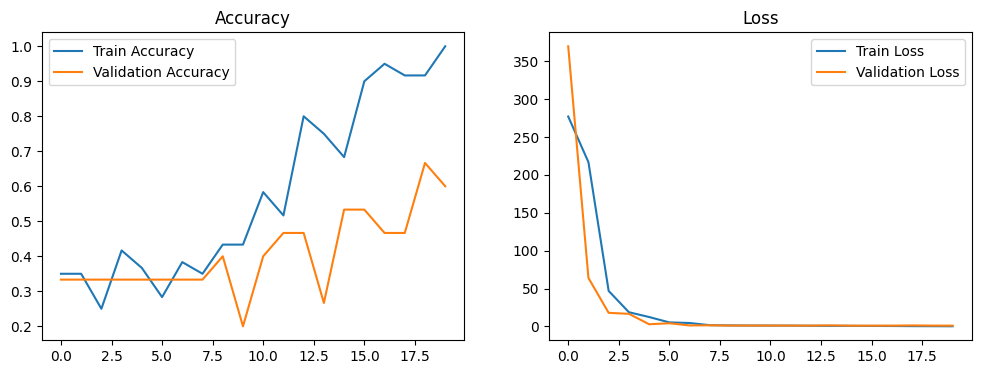

In [12]:
# Early stopping to prevent overfitting
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    # callbacks=[early_stopping]
)

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [13]:
# Predictions
y_pred = np.argmax(model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)

# Classification report
class_labels = label_binarizer.classes_
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Classification Report:
              precision    recall  f1-score   support

          WE       0.50      0.40      0.44         5
        comp       0.50      0.40      0.44         5
     natural       0.71      1.00      0.83         5

    accuracy                           0.60        15
   macro avg       0.57      0.60      0.57        15
weighted avg       0.57      0.60      0.57        15

Confusion Matrix:
[[2 2 1]
 [2 2 1]
 [0 0 5]]


In [14]:
model.save("sensor_condition_classifier.h5")
print("Model saved successfully.")

Model saved successfully.


try to apply cnn model with all the four tasks.

visualize all the images, under different condition subfolder, and 

In [15]:
# Define the path to save images
image_folder = f'{data_path}/images'  

In [ ]:
# Create the folder if it doesn't exist
os.makedirs(image_folder, exist_ok=True)

In [ ]:
# Define specific colors for each measurement (Acc, Gyro, Mag, Quat)
color_dict = {
    'Acc_X': 'r',  # Red for Acc_X
    'Acc_Y': 'g',  # Green for Acc_Y
    'Acc_Z': 'b',  # Blue for Acc_Z
    'Gyr_X': 'c',  # Cyan for Gyr_X
    'Gyr_Y': 'm',  # Magenta for Gyr_Y
    'Gyr_Z': 'y',  # Yellow for Gyr_Z
    'Mag_X': 'k',  # Black for Mag_X
    'Mag_Y': 'orange',  # Orange for Mag_Y
    'Mag_Z': 'purple',  # Purple for Mag_Z
    'Quat_W': 'pink',  # Pink for Quat_W
    'Quat_X': 'brown',  # Brown for Quat_X
    'Quat_Y': 'gray',  # Gray for Quat_Y
    'Quat_Z': 'lime'  # Lime for Quat_Z
}

# Group the data by participant, body_part, condition, and task
for (participant, body_part, condition), group in imu_df.groupby(['participant', 'body_part', 'condition']):
    # Ensure you use a unique name for each task
    for task in group['task'].unique():
        task_group = group[group['task'] == task]
        
        # Plot the four measurements (Acc, Gyro, Mag, Quat) for the current task
        fig, axes = plt.subplots(4, 1, figsize=(15, 10))  # 4 measurements in a column
        fig.suptitle(f'{participant}_{body_part}_{condition}_{task}')

        # Plot Acc_X, Acc_Y, Acc_Z for accelerometer data
        axes[0].plot(task_group['PacketCounter'], task_group['Acc_X'], label='Acc_X', color=color_dict['Acc_X'])
        axes[0].plot(task_group['PacketCounter'], task_group['Acc_Y'], label='Acc_Y', color=color_dict['Acc_Y'])
        axes[0].plot(task_group['PacketCounter'], task_group['Acc_Z'], label='Acc_Z', color=color_dict['Acc_Z'])
        axes[0].set_ylabel('Accelerometer', labelpad=15)
        axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

        # Plot Gyro_X, Gyro_Y, Gyro_Z for gyroscope data
        axes[1].plot(task_group['PacketCounter'], task_group['Gyr_X'], label='Gyr_X', color=color_dict['Gyr_X'])
        axes[1].plot(task_group['PacketCounter'], task_group['Gyr_Y'], label='Gyr_Y', color=color_dict['Gyr_Y'])
        axes[1].plot(task_group['PacketCounter'], task_group['Gyr_Z'], label='Gyr_Z', color=color_dict['Gyr_Z'])
        axes[1].set_ylabel('Gyroscope', labelpad=15)
        axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

        # Plot Mag_X, Mag_Y, Mag_Z for magnetometer data
        axes[2].plot(task_group['PacketCounter'], task_group['Mag_X'], label='Mag_X', color=color_dict['Mag_X'])
        axes[2].plot(task_group['PacketCounter'], task_group['Mag_Y'], label='Mag_Y', color=color_dict['Mag_Y'])
        axes[2].plot(task_group['PacketCounter'], task_group['Mag_Z'], label='Mag_Z', color=color_dict['Mag_Z'])
        axes[2].set_ylabel('Magnetometer', labelpad=15)
        axes[2].legend(loc='upper left', bbox_to_anchor=(1, 1))

        # Plot Quat_W, Quat_X, Quat_Y, Quat_Z for quaternion data
        axes[3].plot(task_group['PacketCounter'], task_group['Quat_W'], label='Quat_W', color=color_dict['Quat_W'])
        axes[3].plot(task_group['PacketCounter'], task_group['Quat_X'], label='Quat_X', color=color_dict['Quat_X'])
        axes[3].plot(task_group['PacketCounter'], task_group['Quat_Y'], label='Quat_Y', color=color_dict['Quat_Y'])
        axes[3].plot(task_group['PacketCounter'], task_group['Quat_Z'], label='Quat_Z', color=color_dict['Quat_Z'])
        axes[3].set_ylabel('Quaternions', labelpad=15)
        axes[3].legend(loc='upper left', bbox_to_anchor=(1, 1))

        # Save the image with a name based on the participant, body part, condition, and task
        image_name = f"{participant}_{body_part}_{condition}_{task}.png"
        image_path = os.path.join(image_folder, image_name)
        plt.savefig(image_path)
        plt.close()  # Close the plot to save memory

        print(f"Saved image: {image_path}")


In [ ]:
# Organize the folder for image
class_folders = ['natural', 'comp', 'comp_WE'] 

In [ ]:
# Create subfolders for each class
for folder in class_folders:
    os.makedirs(os.path.join(image_folder, folder), exist_ok=True)

In [ ]:
# Move images into corresponding folders based on filename
for file_name in os.listdir(image_folder):
    if file_name.endswith('.png'):  # Ensure it's a .png file
        # Extract the condition from the filename
        if 'comp_WE' in file_name:
            target_folder = 'comp_WE'
        elif 'comp' in file_name:
            target_folder = 'comp'
        elif 'natural' in file_name:
            target_folder = 'natural'
        else:
            continue  # Skip if no condition is found
        
        # Move the file to the correct folder
        shutil.move(os.path.join(image_folder, file_name), 
                    os.path.join(image_folder, target_folder, file_name))

print("Images have been reorganized.")

In [178]:
# Parameters for the image size
img_width, img_height = 128, 128  # Resize all images to 128x128
batch_size = 32
epochs = 20

In [ ]:
# Step 1: Set up ImageDataGenerator for loading and preprocessing images
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [ ]:
# Step 2: Load images from folders into train and validation sets
train_generator = datagen.flow_from_directory(
    image_folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',  # Since we're doing multi-class classification
    subset='training'  # Use the subset for training
)

validation_generator = datagen.flow_from_directory(
    image_folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',  # Same as for training
    subset='validation'  # Use the subset for validation
)

In [ ]:
# Step 3: Define the CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Assuming 3 classes
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Step 4: Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Step 5: Train the model
history_all = model.fit(
    train_generator,  # The training data generator
    validation_data=validation_generator,  # The validation data generator
    epochs=epochs,  # Number of epochs
    batch_size=batch_size,  # Batch size (this is handled by the generator)
    # callbacks=[early_stopping]  # Early stopping to prevent overfitting
)

In [ ]:
# Step 6: Save the trained model
model.save("cnn_condition_classifier.h5")

In [ ]:
# Step 8: Evaluate the model
y_pred = np.argmax(model.predict(validation_generator), axis=1)
y_true = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

try to use cnn with separate tasks

In [7]:
# Function to extract task name from the image filename
def extract_task_name(image_name):
    task_name = image_name.split('.')[0].split('_')[-1]  # Get the last part of the filename 
    return task_name

In [8]:
# Iterate through the condition folders in the image folder
for condition_folder in os.listdir(image_folder):
    condition_path = os.path.join(image_folder, condition_folder)
    
    # Check if the folder is a directory (condition folder)
    if os.path.isdir(condition_path):
        # Iterate through the images in each condition folder
        for image_name in os.listdir(condition_path):
            if image_name.endswith('.png'):  # Only process PNG images
                # Extract the task name from the image file
                task = extract_task_name(image_name)

                # Create the task folder inside the condition folder if it doesn't exist
                task_folder = os.path.join(condition_path, task)
                if not os.path.exists(task_folder):
                    os.makedirs(task_folder)

                # Move the image into the task folder
                source_path = os.path.join(condition_path, image_name)
                destination_path = os.path.join(task_folder, image_name)
                shutil.move(source_path, destination_path)

                print(f"Moved {image_name} to {destination_path}")

In [9]:
# Set image size and batch size
img_width, img_height = 150, 150  # Image size for CNN input
batch_size = 32

In [10]:
# Step 1: Prepare the ImageDataGenerator for training and validation
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize the image pixels to [0, 1]
    validation_split=0.2  # 80% for training, 20% for validation
)

In [11]:
# Step 2: Load images from directories
train_generator = datagen.flow_from_directory(
    image_folder,
    target_size=(img_width, img_height),  # Resize images to fit the model input
    batch_size=batch_size,
    class_mode='categorical',  # Multi-class classification
    subset='training'  # Specify training data
)

validation_generator = datagen.flow_from_directory(
    image_folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',  # Same as for training
    subset='validation'  # Specify validation data
)

In [12]:
# Step 3: Build the CNN Model
from tensorflow.keras import layers, models
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(train_generator.num_classes, activation='softmax')  # Output layer: number of classes
])

Found 240 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [22]:
# Step 4: Compile the Model
model.compile(
    optimizer='adam',  # Optimizer for training
    loss='categorical_crossentropy',  # Loss function for multi-class classification
    metrics=['accuracy']  # Metrics to track during training
)

In [24]:
# Step 5: Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch = len(train_generator) // batch_size,
    epochs=50,  # Number of epochs to train for
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9881 - loss: 0.0394 - val_accuracy: 0.4688 - val_loss: 2.7748
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9979 - loss: 0.0179 - val_accuracy: 0.4688 - val_loss: 2.0141
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 1.0000 - loss: 0.0084 - val_accuracy: 0.3125 - val_loss: 3.4698
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 1.0000 - loss: 0.0066 - val_accuracy: 0.3438 - val_loss: 3.7915
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9935 - loss: 0.0101 - val_accuracy: 0.3750 - val_loss: 3.3146
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.5312 - val_loss: 2.5946
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 1.0000 - loss: 5.6177e-04 - val_accuracy: 0.4688 - val_loss: 2.9133
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 1.0000 - loss: 9.0425e-04 - val_accuracy: 0.4375 - val_loss: 2.8049
Epoch

In [25]:
# Step 6: Save the trained model
model.save('task_cnn_model.h5')

In [14]:
# Step 7: Evaluate the Model 
test_loss, test_acc = model.evaluate(validation_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

/Users/daikexin/pythonProject/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2867 - loss: 1.1256 - val_accuracy: 0.2812 - val_loss: 1.1042
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3448 - loss: 1.1076 - val_accuracy: 0.3125 - val_loss: 1.1027
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 991ms/step - accuracy: 0.3648 - loss: 1.0920 - val_accuracy: 0.2812 - val_loss: 1.1006
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 983ms/step - accuracy: 0.3064 - loss: 1.1094 - val_accuracy: 0.3750 - val_loss: 1.0924
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 968ms/step - accuracy: 0.2892 - loss: 1.1052 - val_accuracy: 0.3750 - val_loss: 1.0920
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.3551 - loss: 1.0989 - val_accuracy: 0.3125 - val_loss: 1.1015
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 962ms/step - accuracy: 0.3342 - loss: 1.0940 - val_accuracy: 0.4375 - val_loss: 1.0983
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 953ms/step - accuracy: 0.3588 - loss: 1.0922 - val_accuracy: 0.4688 - val_loss: 1.0950
